In [ ]:
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import zipfile
import requests
import albumentations as A
import cv2
import os

from tensorflow.keras.utils import PyDataset
from dataclasses import dataclass

In [ ]:
# To Download processed dataset.
def download_file(url, save_name):
    file = requests.get(url)
    open(save_name, 'wb').write(file.content)

In [ ]:
# To Unzip the dataset file.
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [ ]:
save_name = "dataset_SUIM.zip"

if not os.path.exists(save_name):
    download_file(
        'https://www.dropbox.com/s/1g2y2nu9v7gizu9/dataset_SUIM.zip?dl=1',
        save_name
    )

    unzip(zip_file=save_name)

Extracted all


In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 6
    IMG_WIDTH:   int = 256
    IMG_HEIGHT:  int = 256
    DATA_TRAIN_IMAGES: str = 'dataset_SUIM/train/images/*.jpg'
    DATA_TRAIN_LABELS: str = 'dataset_SUIM/train/masks/*.bmp'
    DATA_VALID_IMAGES: str = 'dataset_SUIM/valid/images/*.jpg'
    DATA_VALID_LABELS: str = 'dataset_SUIM/valid/masks/*.bmp'
    DATA_TEST_IMAGES:  str = 'dataset_SUIM/test/images/*.jpg'
    DATA_TEST_LABELS:  str = 'dataset_SUIM/test/masks/*.bmp'

In [ ]:
# Custom Class for creating training and validation (segmentation) dataset objects.
class CustomSegDataLoader(PyDataset):

    def __init__(self, batch_size, image_size, image_paths, mask_paths, num_classes, aug, **kwargs):

        super().__init__(**kwargs)


        self.batch_size  = batch_size
        self.image_size  = image_size
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.num_classes = num_classes
        self.aug = aug

        self.x = np.empty((self.batch_size,) + self.image_size + (3,), dtype="float32")
        self.y = np.empty((self.batch_size,) + self.image_size, dtype="float32")

        if self.aug:
            self.train_transforms = self.transforms()

        self.resize_transforms = self.resize()

    def __len__(self):

        return len(self.mask_paths) // self.batch_size

    def transforms(self):

        # Data augmentation.
        train_transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0.2,
                               shift_limit=0.2, p=0.5, border_mode=0),
        ])
        return train_transforms

    def resize(self):

        resize_transforms = A.Resize(
            height=self.image_size[0], width=self.image_size[1],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True, p=1
        )
        return resize_transforms

    def reset_array(self):
        self.x.fill(0.)
        self.y.fill(0.)

    def __getitem__(self, idx):
        self.reset_array()
        i = idx * self.batch_size
        batch_image_paths = self.image_paths[i : i + self.batch_size]
        batch_mask_paths = self.mask_paths[i : i + self.batch_size]

        for j, (input_image, input_mask) in enumerate(zip(batch_image_paths, batch_mask_paths)):

            # Read the image and convert to RGB.
            img = cv2.imread(input_image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Read the mask and convert to RGB.
            msk = cv2.imread(input_mask)
            msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

            # Resize the image and mask.
            resized  = self.resize_transforms(image=img, mask=msk)
            img, msk = resized['image'], resized['mask']

            if self.aug:
                # Apply augmentations.
                train_augment = self.train_transforms(image=img, mask=msk)
                img, msk = train_augment['image'], train_augment['mask']

            # Store image in x.
            self.x[j] = img / 255. # Normalizing image to be in range [0.0, 1.0]

            # Convert RGB segmentation mask to multi-channel (one-hot) encoded arrays where
            # each channel represents a single class whose pixel values are either 0 or 1,
            # where a 1 represents a pixel location associated with the class that corresponds
            # to the channel.
            msk = rgb_to_onehot(msk)

            # Convert the multi-channel (one-hot encoded) mask to a single channel (grayscale)
            # representation whose values contain the class IDs for each class (essentially
            # collapsing the one-hot encoded arrays into a single channel).
            self.y[j] = msk.argmax(-1)

        return self.x, self.y

In [ ]:
id2color = {
    0: (0,  0,    0),    # BW: Background/waterbody
    1: (0,  0,    255),  # HD: Human divers
    2: (0,  255,  255),  # WR: Wrecks and ruins
    3: (255, 0,   0),    # RO: Robots and instruments
    4: (255, 0,   255),  # RI: Reefs and invertebartes
    5: (255, 255, 0),    # FV: Fish and vertebrates
 }

In [ ]:
# Function to one-hot encode RGB mask labels.
def rgb_to_onehot(rgb_arr, color_map=id2color, num_classes=DatasetConfig.NUM_CLASSES):

    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros( shape, dtype=np.float32 )

    for i, classes in enumerate(color_map):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_map[i], axis=1).reshape(shape[:2])

    return arr

In [ ]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):

    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[single_layer==k] = color_map[k]

    return np.float32(output) / 255. # return a floating point array in range [0.0, 1.0]

In [ ]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [ ]:
def display_image_and_mask(data_list, color_mask=False, color_map=id2color):

    plt.figure(figsize=(16, 6))
    title = ['GT Image', 'GT Mask', 'Overlayed Mask']

    grayscale_gt_mask = data_list[1]

    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)

    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], rgb_gt_mask)

    data_list.append(overlayed_image.clip(0.0, 1.0))

    for i in range(len(data_list)):
        plt.subplot(1, len(data_list), i+1)
        plt.title(title[i])
        if title[i] == 'GT Mask':
            if color_mask:
                plt.imshow(np.array(rgb_gt_mask))
            else:
                plt.imshow(np.array(grayscale_gt_mask))
        else:
            plt.imshow(np.array(data_list[i]))
        plt.axis('off')

    plt.show()

In [ ]:
# Using Custom Data Loader class
def create_datasets(aug=False):

    # Training image and mask paths.
    train_images = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_IMAGES}"))
    train_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_TRAIN_LABELS}"))

    # Validation image and mask paths.
    valid_images = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_IMAGES}"))
    valid_masks  = sorted(glob.glob(f"{DatasetConfig.DATA_VALID_LABELS}"))

    # Train data loader.
    train_ds = CustomSegDataLoader(batch_size=8,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=train_images,
                                   mask_paths=train_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=aug,
                                   workers = 4,
                                   use_multiprocessing = True
                                  )
    # Validation data loader.
    valid_ds = CustomSegDataLoader(batch_size=8,
                                   image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                   image_paths=valid_images,
                                   mask_paths=valid_masks,
                                   num_classes=DatasetConfig.NUM_CLASSES,
                                   aug=False,
                                   workers = 4,
                                   use_multiprocessing = True
                                  )

    return train_ds, valid_ds

In [ ]:
train_ds, valid_ds = create_datasets(aug=True)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-584932955.py:40: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  resize_transforms = A.Resize(


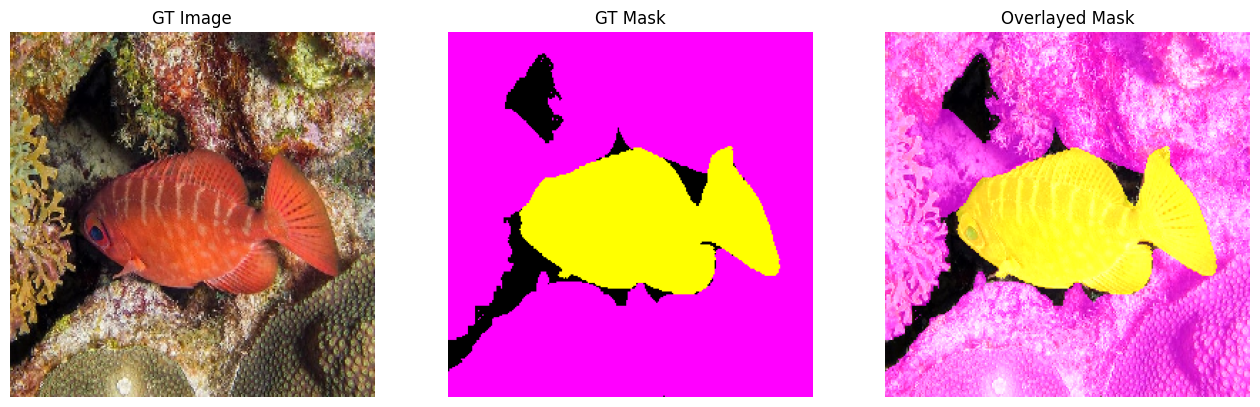

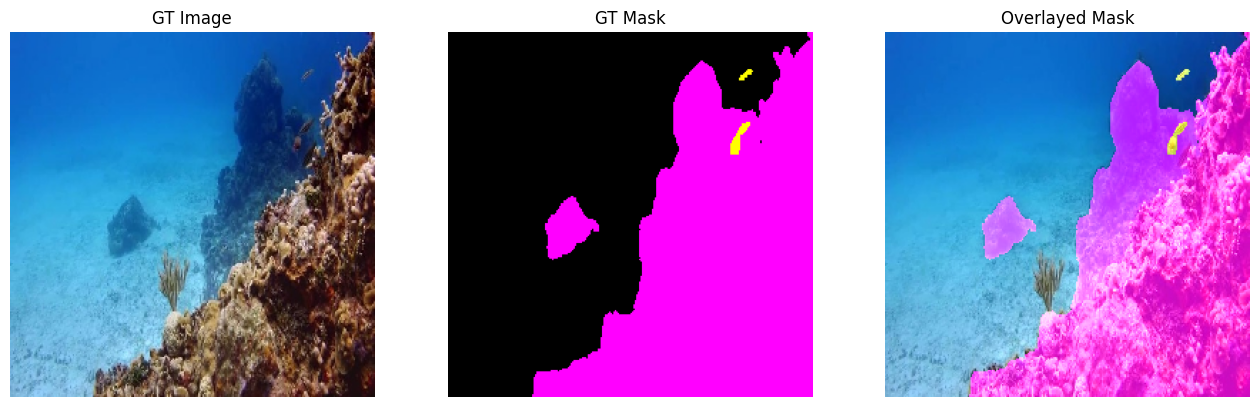

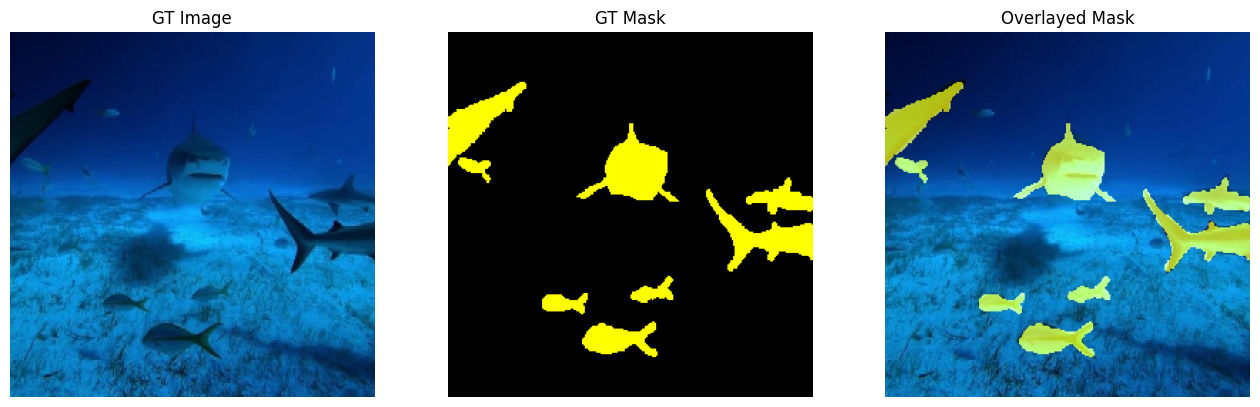

In [ ]:
# Display sample images
for i, (images, masks) in enumerate(valid_ds):
    if i == 3:
        break
    # Retrieve last image in data batch as an example.
    image, mask = images[-1], masks[-1]
    display_image_and_mask([image, mask], color_mask=True)